In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import  timedelta
import pandas as pd
import math
import scipy.stats as stats
import os
print(os.getcwd())

/Users/ivan/Documents/GoreInterview


## Step 1: Defining a time-Homogeneous Compound Poisson Process(HCPP) Simulator
We employ methods from Karl Sigman, http://www.columbia.edu/~ks20/4404-Sigman/4404-Notes-NSP.pdf
to simulate a HCPP, where the indexing Poisson Process has a mean rate of $\lambda t$, and the 
indexed random variables Y_i are Normally distributed with parameters $(\mu, \sigma^2)$.
The default parameters for this simulator follow the presentation such that $(\lambda, \mu, sigma^2) = (1,0, 0.0018)$.
The default HCPP period length is 60 seconds. 

In [19]:
# poisson process 
from cmath import log
from copy import copy
class hcpp():
    """
    Atributtes
    ----------
    lam : float
        set defect arrival rate lambda.
    mu : float
        set mean defect size.
    sig2: float
        set variance of defect size, under the assumption of normally
        distributed defect sizes. 
    period_length : float
        length of HCPP simulation in seconds.
    now : datetime object
        time when class is initiated, referece 0 time. 
    timestamps : list
        list of timestamps of HCPP arrvials.
    rvs : list
        list of the size of random variables(RV). 
        must be same length as timestamps.
    hcpp_process = list
        list of cumulative sum of HCPP process. 

    Methods
    -------
    get_hcpp_arrival()
        Generates HCPP RV with timestamp and size.
    get_hcpp_sequence()
        Generates a sequence of HCPP RVs.
    convert_tstamp_to_sec()
        Converts list of timestamps, self.timestamps to a list of timepoints in seconds.
    """
    def __init__(self):
        self.lam = 1.0
        self.mu,self.sig2 = 0.5, 0.05
        self.period_length = 60.0
        self.now = dt.datetime.now()
        self.timestamps = [copy(self.now)]
        self.rvs = [0]
        self.hcpp_process = [0]
        
    def get_hcpp_arrival(self):
        """
        Generates HCPP RV with timestamp and size.
        """
        arrival_time = (-1/self.lam)*math.log(np.random.default_rng().uniform())
        self.now += dt.timedelta(seconds = arrival_time)
        rv = np.random.default_rng().normal(self.mu,self.sig2)
        return self.now, rv

    def get_hcpp_sequence(self):
        """
        Generates a sequence of HCPP RVs.
        Updates the HCPP process. 
        """
        period_end = copy(self.now) + dt.timedelta(seconds = self.period_length)
        while self.now < period_end:
            arrivaltime, rv = self.get_hcpp_arrival()
            hcpp_proc = self.hcpp_process[-1] + rv
            self.rvs.append(rv)
            self.timestamps.append(arrivaltime)
            self.hcpp_process.append(hcpp_proc)

def convert_tstamp_to_sec(timestamps):
    """
    Converts list of timestamps, self.timestamps to a list of timepoints in seconds.
    """
    return [(tstamp - timestamps[0]).total_seconds() for tstamp in timestamps]

## Step 2: Generating a Sequence of HCPP Random Variables (RV)
For a set $(\lambda, \mu, \sigma^2) = (1,0, 0.0018)$, we simulate a HCPP for 60 seconds, and plot the results below. 


The mean size and number of the defects were estimated to be 0.48768 mm, and 0.9508 defects per second.


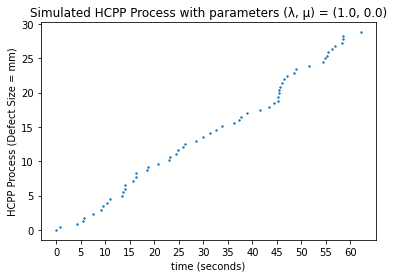

In [20]:
hcpp_inst = hcpp()
hcpp_inst.get_hcpp_sequence()

print(
    "The mean size and number of the defects were estimated to be {} mm, and {} defects per second.".format(
        round(np.mean(hcpp_inst.rvs),5),round(len(hcpp_inst.rvs)/(hcpp_inst.timestamps[-1]-hcpp_inst.timestamps[0]).total_seconds(),4)
    ))
timepoints = convert_tstamp_to_sec(hcpp_inst.timestamps)
rvs = hcpp_inst.hcpp_process

def plot_HCPP_Process(timepoints,rvs,ticksize=5,params='(\u03BB, \u03BC) = (1.0, 0.0)',figtitle="fig1"):
    plt.scatter(x=timepoints, y=rvs, s=2)
    plt.title("Simulated HCPP Process with parameters {}".format(params))
    plt.xticks(np.arange(min(timepoints), max(timepoints), ticksize))
    plt.xlabel("time (seconds)")
    plt.ylabel("HCPP Process (Defect Size = mm)")
    plt.savefig(figtitle,dpi=100)
    plt.show()

plot_HCPP_Process(timepoints, rvs, figtitle="fig_single_HCPP.jpg")

## Step 3: Testing Goodness of Fit (GOF) for Simulated HCPP.
To confirm whether the HCPP process follows each individual distribution we use:

1. MLE estimator and $\chi^2$ Goodness of Fit test for parameter, $\lambda$,

2. Lilliefor's test of Normality for *size* random variables we assumed were normally distributed.
  
  *Note: While Lilliefor's test was not covered in this presentation you can learn more at,
  http://www.columbia.edu/~ww2040/NHPP_NRL_final.pdf

For the $\chi^2$ test where the MLE estimate of the mean No. of defects in a period length $t$ is $\hat \lambda t$ the Hypotheses are:

$\qquad H_0$: The mean rate of order arrival in a 1s increment $ = \hat \lambda t$.

$\qquad H_1$: The mean rate of order arrival in a 1s increment $ \neq \hat \lambda t$.

For the Lilliefor's test of Normality is a non parametric test, so we take the hypotheses to be:

$\qquad H_0$: The size of defects $Y_0, Y_1, \ldots Y_{N(t)}$ are normally distributed.

$\qquad H_1$: The size of defects $Y_0, Y_1, \ldots Y_{N(t)}$ are not normally distributed.

In [21]:
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import ksone
def compute_gof(hcpp_inst,distr,alpha):
    df = pd.Series(hcpp_inst.rvs, index = hcpp_inst.timestamps)
    dfrs = df.resample('s').agg({'Poisson':'size','Exponential':'sum'})
    if distr == 'poisson':
        Obs = dfrs['Poisson']
        hatlamt = dfrs['Poisson'].sum()/hcpp_inst.period_length
        Exp = [hatlamt]*len(Obs)
        chi_square_test_stat = 0
        for i in range(len(Obs)):
            chi_square_test_stat += (np.square(Obs[i]-Exp[i]))/Exp[i]
        print('chi square value determined by formula : ' +
            str(chi_square_test_stat))     
        print('chi square critical value at alpha = {}: {}'.format(alpha, stats.chi2.ppf(1-alpha, df=len(Obs)-1)))
    elif distr == 'norm' or 'exp':
        ksstat, pval = lilliefors(hcpp_inst.rvs, dist=distr)
        print("KS value determined by lilliefors test:", ksstat)
        print('KS critical value at alpha = {}: {}'.format(alpha, ksone.ppf(1-(alpha/2),len(hcpp_inst.rvs))))
    else:
        print("please write 'poisson', 'exp','norm' as arg for dist.")   
    
#Chi-Sq for Poisson
compute_gof(hcpp_inst, 'poisson',0.05)
  
#Lilliefor's for Normally or Exponential
compute_gof(hcpp_inst, 'norm', 0.05)

chi square value determined by formula : 58.865254237288134
chi square critical value at alpha = 0.05: 81.3810151888991
KS value determined by lilliefors test: 0.15413892501473478
KS critical value at alpha = 0.05: 0.17373142290901578


### Evaluating Results from GOF tests:
We see that neither computed statistic, $\chi^2$ and $KS_{stat}$, exceeded their critical values at an $\alpha = 0.05$.
We can conclude for now that we can

1. simulate a HCPP process $Q(t)$,
  
    * with an indexing Poisson process with mean rate of arrival $\lambda$,

    * time-invariant Normally distributed process $Y_{N(t)}$ with mean, $\mu$, and variance $\sigma^2$.

2. We can estimate, and assess goodness of fit of
  
    * the mean no of defects $\hat \lambda t$using the $\chi^2$ GOF test.
  
    * the parameters $(\hat \mu,\hat \sigma^2)$ using Lilliefor's test.

## Step 4: Simulating a HCPP with a changepoint to an increased rate of Defect Arrivals
Next we will simulate a HCPP that:
    
1. Begins at an initial $\lambda_0 = 1$ Defect/s,
    
2. proceeds with this $\lambda_0$ for 60 seconds,
    
3. changes its rate of Defect arrival to $\lambda_1 = 5$ Defects/s,
    
4. finally proceeds with this $\lambda_0$ for 60 seconds.

1.4528662053695391
0.45573198775984236
0.45573198775984236


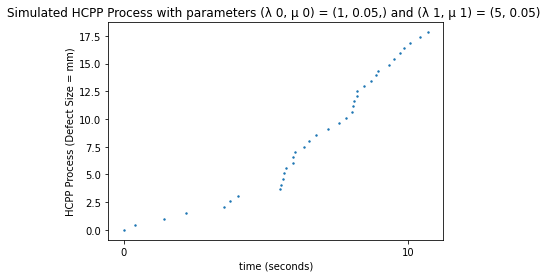

In [22]:
hcpp_inst = hcpp()
hcpp_inst.period_length = 5
hcpp_inst.get_hcpp_sequence()
lam_est = len(hcpp_inst.rvs)/(hcpp_inst.timestamps[-1]-hcpp_inst.timestamps[0]).total_seconds()
mu_est = np.mean(hcpp_inst.rvs)
print(lam_est)
print(np.mean(hcpp_inst.rvs))
hcpp_inst.lam = 5
hcpp_inst.get_hcpp_sequence()
print(mu_est)
timepoints = convert_tstamp_to_sec(hcpp_inst.timestamps)
plot_HCPP_Process(timepoints, hcpp_inst.hcpp_process, ticksize=10,params="(\u03BB 0, \u03BC 0) = (1, 0.05,) and (\u03BB 1, \u03BC 1) = (5, 0.05) ")

In [9]:
# #Poisson 
compute_gof(hcpp_inst, 'poisson',0.05)
  
# find Chi-Square critical value
compute_gof(hcpp_inst, 'norm', 0.05)

chi square value determined by formula : 317.6510156971373
chi square critical value at alpha = 0.05: 146.56735758076744
KS value determined by lilliefors test: 0.057571917082879315
KS critical value at alpha = 0.05: 0.07100041370574829


## Step 6: GOF test results
We see that only the $\chi^2$ statistic exceeded its critical values at an $\alpha = 0.05$.

This creates a new problem! Suppose at some unknown time $\nu$, the rate of Defect arrival changes from $\lambda_0$ to $\lambda_1$.
How do develop a change point detection scheme to identify when this change occurs. 
## Step 7: CUSUM Changepoint Detection Scheme 
Starting again with our HCPP process, $\{Q(t)\}_{t\geq0}$ with mean $\lambda_0 \mu t$, where $\lambda_1^+=(1+\epsilon)\lambda_0$, $\lambda_1^-= (1-\epsilon)\lambda_0$, $\{h, \lambda_0, \epsilon, \mu \} \in \mathbb{R^+}$ we can define the CUSUM class that generates 6 processes:

1.$ u^+_t (\lambda_0, \mu)$; The SPRT process to detect a change from a upward change.

2.$ m^+_t (\lambda_0, \mu)$; The running minimum of the upward SPRT process, $u^+_t$.

3.$u^-_t (\lambda_0,\mu)$; The SPRT process to detect a change from a downward change.
                
4.$m^-_t (\lambda_0,\mu)$; The running minimum of the downward SPRT process, $u^-_t$.

5.$y^+_t (\lambda_0, \mu)$; The CUSUM process for an upward change.

6.$y^-_t (\lambda_0, \mu)$; The CUSUM process for an downward change.

This CUSUM detection scheme will identify the CUSUM stopping time $\tau$:
$$ \tau = \inf \{ t \geq 0; y^+_t(\lambda_0, \mu) \lor y^-_t(\lambda_0, \mu) \geq h \} $$

In [23]:
class CUSUM(object): 
    def __init__(self, timestamp=dt.datetime(1900,1,1), l0=1.0, epsilon = 0.01, h = 0.0001):
        # from args
        self.l0 = l0
        self.deltatime = 0.0
        self.h = h
        self.Y = 0
        self.epsilon = epsilon
        self.alarm_up,self.alarm_dn = False, False 
        self.timestamp = timestamp
        self.entries = []
        #derived
        self.SPRT_dn, self.SPRT_up = 0.0, 0.0
        self.run_min_dn, self.run_min_up = 0.0, 0.0
        self.CUSUM_dn, self.CUSUM_up = 0.0, 0.0
        self.write_to_df()

    def reset_CUSUM(self):
        self.SPRT_dn, self.SPRT_up = 0.0, 0.0
        self.run_min_dn, self.run_min_up = 0.0, 0.0
        self.CUSUM_dn, self.CUSUM_up = 0.0, 0.0
        self.alarm_up,self.alarm_dn = False, False 

    def compute_stats(self, Y, deltatime, timestamp):
        self.Y = Y
        self.timestamp = timestamp
        self.SPRT_up +=  Y*math.log(1 + self.epsilon) - deltatime*self.l0*self.epsilon
        self.SPRT_dn +=  Y*math.log(1 - self.epsilon) + deltatime*self.l0*self.epsilon
        self.run_min_up = min(self.run_min_up, self.SPRT_up)
        self.run_min_dn = min(self.run_min_dn, self.SPRT_dn)
        self.CUSUM_up = self.SPRT_up - self.run_min_up
        self.CUSUM_dn = self.SPRT_dn - self.run_min_dn
    
    def check_alarms(self):
        if self.CUSUM_dn > self.h:
            self.alarm_dn = True
            self.l0 = self.l0*(1-self.epsilon)
        else:
            self.alarm_dn = False

        if self.CUSUM_up > self.h:
            self.alarm_up = True 
            self.l0 = self.l0*(1+self.epsilon)
        else:
            self.alarm_up = False

    
    def write_to_df(self):
        record_to_insert = {
                    'timestamp':self.timestamp,
                    'size':self.Y,
                    'SPRTup':self.SPRT_up,
                    'runminup':self.run_min_up,
                    'CUSUMup':self.CUSUM_up,
                    'SPRTdn':self.SPRT_dn,
                    'runmindn':self.run_min_dn,
                    'CUSUMdn':self.CUSUM_dn, 
                    'alarmup':self.alarm_up,
                    'alarmdn':self.alarm_dn,
        } 
        self.entries.append(record_to_insert)

    def Update(self, Y, deltatime, timestamp):
        self.compute_stats(Y=Y, deltatime=deltatime,timestamp=timestamp)
        self.check_alarms()
        self.write_to_df()
        if self.alarm_up or self.alarm_dn:
            self.reset_CUSUM()

## Step 8: Trying Out our CUSUM Changepoint Detection Scheme
Lets try to use our change point detection scheme to identify a stopping time $\tau$ where we can say the simulated HCPP no longer has the mean rate $\lambda0$. We will:
    
1. Generate a HCPP with $\lambda_0 = 1$ Defect/s, that runs for 60 seconds.

2. Record estimates for $\hat \lambda_0 \hat \mu t for that initial run.

3. Start recording out CUSUM statistics, 

4. Continue simulating the HCPP for 60 more seconds,

4. changes the HCPP rate of Defect arrival to $\lambda_1 = 5$ Defects/s,
    
5. finally proceeds with this $\lambda_0$ for 60 seconds.

from this data, we will generate a table of the CUSUM statistics.


In [34]:
## lets try this test
hcpp_inst = hcpp()
hcpp_inst.period_length = 5
hcpp_inst.get_hcpp_sequence()
lammutest = len(hcpp_inst.rvs)*np.mean(hcpp_inst.rvs)
print("the estimated initial rate*size of defect arrivals is {}".format(lammutest))
hcpp_inst.__init__()
hcpp_inst.get_hcpp_sequence()
hcpp_inst.lam=5
hcpp_inst.get_hcpp_sequence()

CUSUM_inst = CUSUM(timestamp = hcpp_inst.timestamps[0], l0=lammutest)
CUSUM_inst.h = 0.05
times = convert_tstamp_to_sec(hcpp_inst.timestamps)
for i in range(1,len(times)):
    deltatime = times[i] - times[i-1]
    CUSUM_inst.Update(Y=hcpp_inst.rvs[i],deltatime = deltatime, timestamp =hcpp_inst.timestamps[i])
    
df = pd.DataFrame(CUSUM_inst.entries)
df['time'] = convert_tstamp_to_sec(df['timestamp'])

the estimated initial rate*size of defect arrivals is 1.5214395538247474


## Step 9 Plotting CUSUM Processes 

In [47]:
def CUSUM_SPRT_runmin_chart(df):
    fig, ax = plt.subplots(3, sharex=True)
    #top graph
    ax[0].title.set_text('Defect CUSUMs Process')
    ax[0].scatter(df['time'], df['CUSUMup'], s=1, color='purple', label='CUSUM up')
    ax[0].scatter(df['time'], df['CUSUMdn'], s=1, color='green', label='CUSUM dn')
    #middle graph
    ax[1].title.set_text('SPRT processes')
    ax[1].scatter(df['time'], df['SPRTup'], s=1, color='red', label='SPRT up')
    ax[1].scatter(df['time'], df['SPRTdn'], s=1, color='blue', label='SPRT dn')
    #bottom graph
    ax[2].title.set_text('running min processes')
    ax[2].scatter(df['time'], df['runminup'], s=1, color='blue', label='runmin up')
    ax[2].scatter(df['time'], df['runmindn'], s=1, color='gold', label='runmin dn')
    #label settings
    ax[0].set_xlabel("Time (s)")
    ax[1].set_xlabel("Time (s)")
    ax[2].set_xlabel("Time (s)")
    plt.xlim(df['time'].iloc[0], df['time'].iloc[-1])
    ax[0].set_ylabel("CUSUM Statistic")
    ax[1].set_ylabel("SPRT Statistic")
    ax[2].set_ylabel("runmin Statistic")
    #display options
    for _ in range(3):
        ax[_].legend(loc= 'center left',bbox_to_anchor=(1,0.5) )
    plt.tight_layout()
    plt.savefig("fig_3_CUSUM_construction.png")
    plt.show()

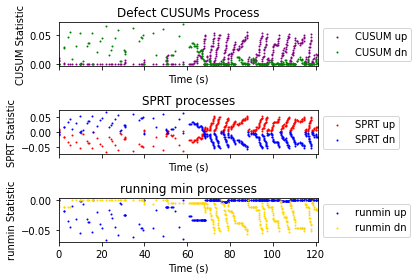

In [48]:
CUSUM_SPRT_runmin_chart(df)